In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 1. 生成数据集
构造人造数据集
- 1000个样本数据集
- 每个样本包含从 标准正态分布 采样的 2个特征
- $X \in R^{1000*2}$
- $w=[2,-3.4]^T;b=4.2$
- $y=Xw+b+\epsilon, \epsilon \sim N(0,\sigma^2)$
- 将标准差设置为 0.01

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y=Xw + b + epsilon噪声"""
    # 均值为0、标准差为1的正态分布 生成一个张量 X
    X = torch.normal(0, 1, (num_examples, len(w)))
    # 矩阵乘法, 形成一个理想的（无噪声）标签 y
    y = torch.matmul(X, w)+ b
    # 标签加上均值为0、标准差为0.01的小噪声，模拟真实世界中数据的不完美
    y += torch.normal(0, 0.01, y.shape)
    # y 使用 reshape((-1, 1)) 转换成二维列向量形式（方便后续处理）
    # -1：自动推断行数，  1：固定列数为1
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


- features：自变量、输入X
- labels：因变量、真实输出y

In [3]:
print('features:', features[0], '\nlabels:', labels[0])

features: tensor([-0.0954,  0.1875]) 
labels: tensor([3.3593])


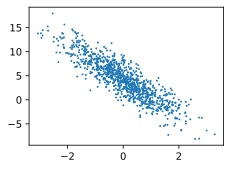

In [4]:
d2l.set_figsize()
# 在pytorch的一些版本，需要 detach 才能使用 numpy
d2l.plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(), 1)

# 2. 读取数据集
- 训练模型时要对数据集进行遍历，每次抽取一小批量样本，使用它们来更新模型
- 定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据

In [5]:
def data_iter(batch_size, features, labels):
    # 获取样本总数，比如之前生成的是 1000 条数据
    num_examples = len(features)
    # 创建一个包含所有样本索引的列表，比如 [0, 1, 2, ..., 999]
    indices = list(range(num_examples))
    # 打乱样本顺序，防止模型学到数据的固定顺序
    random.shuffle(indices)
    # for 循环每次从数据集中取出 batch_size 个样本
    for i in range(0, num_examples, batch_size):
        # 取出当前这一个批次的索引
        batch_indices = torch.tensor(
            # range(0, 1000, 10) 会产生 i=0, 10, 20, ..., 990 e.g. [i: min(i+10, 1000)]
            indices[i: min(i + batch_size, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]


`yield` 的作用类似于 `return`，但区别在于：

|            | `return`                     | `yield`                                |
|------------|------------------------------|----------------------------------------|
| 用途       | 返回结果，函数终止            | 返回一个值，**函数暂停但不终止**      |
| 函数类型   | 普通函数                      | 生成器函数                              |
| 多次调用   | 每次调用都从头执行            | 每次调用从上次 `yield` 的地方继续执行 |
| 内存使用   | 一次性把所有值都准备好        | **懒加载**，按需返回一个值            |


**用途场景（比如你上面的例子）：**
- 如果数据很大（比如几百万条训练数据），我们**不想一次性加载进内存**。
- `yield` 可以**每次只取一个批次的数据**，节省内存、效率更高。
- 非常适合机器学习中分批训练（batch training）。

---
普通函数：
```python
def get_all_batches(...):
    return [batch1, batch2, batch3, ...]
```

生成器函数：
```python
def get_batch(...):
    yield batch1
    yield batch2
    yield batch3
    ...
```

前者一次性返回所有批次；
后者每次“迭代”时返回一个批次，处理完再继续。

In [6]:
batch_size = 10

# 3. 初始化模型参数

我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0


In [7]:
# requires_grad 是否计算梯度
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 4. 定义模型


In [8]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

# 5. 定义损失函数

In [9]:
def squared_loss(y_hat, y):
    """
    均方损失
    有的 y 可能是矩阵，或者向量，所以统一 reshape成 y_hat的形状
    """
    return (y_hat - y.reshape(y_hat.shape))**2 /2

# 6. 定义优化算法

In [10]:
# params=w,b
# lr = learning rate
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    # torch.no_grad() 来禁用梯度计算：节省内存
    # 在参数更新过程中，不需要记录梯度（因为优化步骤本身不需要反向传播）
    with torch.no_grad():
        for param in params:
            # 求均值
            param -= lr * param.grad / batch_size
            # 手动把 梯度设置为0
            param.grad.zero_()

# 7. 训练

In [11]:
lr = 0.03
# 代周期数 =epoch,数据扫 3遍
num_epochs = 3
# 方便更换成别的模型
net = linreg
loss = squared_loss

# 数据扫 3遍
for epoch in range(num_epochs):
    # 遍历 data_item 小批量数据获得的 X，y
    for X, y in data_iter(batch_size, features, labels):
        # X和y的小批量损失（y—hat，y）
        l = loss(net(X, w, b), y)
        # 因为 l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 损失求和，再计算关于[w,b]的梯度
        l.sum().backward()
        # 更新梯度的参数
        sgd([w, b], lr, batch_size)
    # 扫完一遍后，不需要再计算梯度
    with torch.no_grad():
        # 扫完一遍后，求所有的 loss
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch +1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.032855
epoch 2, loss 0.000121
epoch 3, loss 0.000051


# 8. 评估训练是否成功

比较真实参数和训练得到的参数

In [12]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-0.0002, -0.0005], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0009], grad_fn=<RsubBackward1>)
